# Starbucks App Reward Program

**Author: Joel Ligma**            
<br>
**Date: May 2020 - July 2020**


**Context**
<br>

The goal of this project was to predict customer with a high likelihood of completing an offer. In the context of this project, completing an offer refers to a customer receiving a promotional offer, viewing the offer, and using it to complete a purchase. One of the main challenges of this project was to generate a single dataset derived from multiple dataset sources and to prepare the data for later analysis. The data files used for this project were sourced from Kaggle:
https://www.kaggle.com/blacktile/starbucks-app-customer-reward-program-data

## Table of Contents
**1) Data Preprocessing and Merging Multiple Datasets** 
- Data Cleaning
- Feature Engineering
- Merging/Concatenating/Joining
<br>

**2) Exploratory Data Analysis (EDA)**
- Summary Statistics
- Univariate Analysis
- Bivariate Analysis
<br>

**3) Data Preparation**
- Feature Correlation
- Dummy Coding
- Training, Validation and Test Split
- Scaling Data
<br>

**4) Model Building & Validation**
- Baseline Accuracy
- Random Forest Classifier
- Neural Network Classifier
- XGBoost Classifier
- Model Comparison
<br>

**5) Saving the Model**
- Saving the Best Performing Model for Future Deployment
<br>

**6) Conclusion**
- Business Implications and Recommendations

# 1) Data Preprocessing and Merging Multple Datasets

In [1]:
# load Modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MultiLabelBinarizer # awesome for multiple values in one cell
import csv # write csv file of the complete dataset
from datetime import date 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler # for scaling
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # model validation
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from sklearn.externals import joblib

C:\Users\joell\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [40]:
# Read in files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

## Examine Dataset One: Portfolio

In [50]:
portfolio.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [51]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


As specified in the source description, the **ID** column listed in the portfolio file refers to **Offer ID**.
<br>

Let's change the name of this column to **Offer ID**.

In [52]:
portfolio.rename(columns = {'id':'offer_id'},inplace=True)

Check for unique values in **Offer Type** and **Channels**. This is not necessarily important here because we only have 10 rows 
but will be useful for bigger datasets. Let's do it anyway.

In [53]:
print("offer_type unique values: {}".format(portfolio['offer_type'].unique()))

offer_type unique values: ['bogo' 'informational' 'discount']


In [54]:
# check for unique values/ combinations in list "channels"
unique_list = [] 
# loop through list      
for channels in portfolio.channels: 
    if channels not in unique_list: 
        unique_list.append(channels) 
        
# print unique combinations
for channels in unique_list: 
    print (channels) 

['email', 'mobile', 'social']
['web', 'email', 'mobile', 'social']
['web', 'email', 'mobile']
['web', 'email']


One can see that both features are not in an appropriate format for machine learning models. Thus, let's create new columns out of these 2 columns with the aim to separate the entries in each row. Subsequently, we will drop the old columns.

In [55]:
# separate the entires in the "channels" column and dummy code them
mlb = MultiLabelBinarizer()
channels_array = mlb.fit_transform(portfolio["channels"])
channels_df = pd.DataFrame(data=channels_array, columns=mlb.classes_)
# merge channels_df with portfolio again
portfolio = pd.concat([portfolio, channels_df], axis=1)

# also dummy code "offer_type" 
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['offer_type'])], axis=1)

# examine if it worked porperly
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [56]:
# quick comment: all missing data in "channels" were assigned a "0"

# drop "channels" and "offer_type" columns since they are now redundant
portfolio.drop("channels", axis=1, inplace=True)
portfolio.drop("offer_type", axis=1, inplace=True)

portfolio.head() # we keep offer_id to be able to merge the data sets later

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


As a result, the first dataset is now ready to be used for machine learning. The **Offer ID** column remains in its current state because it will be used to merge the datasets later on.

## Examine Dataset Two: Transcript

In [57]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [58]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


According to the information given on Kaggle, **Person** refers to **Customer ID** so let's rename this column.

In [59]:
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)

Next, the feature **Value** will be examined.

In [60]:
# check for unique values in "value" column
values_per_key = {}
for d in transcript.value:
    for k, v in d.items():
        values_per_key.setdefault(k, set()).add(v)
counts = {k: len(v) for k, v in values_per_key.items()}
counts

{'offer id': 10, 'amount': 5103, 'offer_id': 8, 'reward': 4}

Looks like the data for multiple columns ended up in this single column or the file didn't read in properly. In its current state the **Value** column contains information from 3 separate columns. This is based on the assumption that **Offer_ID** and **Offer ID** are the same column.

**My approach:**

- split the column into separate columns and store them into a new dataframe
- check values and then combine the two offer_id columns
- drop the old columns
- combine the two dataframes

In [61]:
# split the columns and create new dataframe with these columns
df = transcript["value"].apply(pd.Series)

# combine "offer_id" and "offer id" into a single columns based on NaNs and drop both afterwards
df["offer_id_new"] = df['offer_id'].fillna(df["offer id"])
df.drop(columns = 'offer_id', inplace = True )
df.drop(columns = 'offer id', inplace = True )

# combine the new column with the transcript dataframe again
transcript_1 = pd.concat([transcript, df], axis=1)

# change the "offer_id_new" column label to "offer_id"
transcript_1.rename(columns = {'offer_id_new': 'offer_id'}, inplace = True)

transcript_1.head(10)

,customer_id,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


Looks like it worked as intended. Next, let's drop the original **Value** column since it is now redundant.

In [62]:
transcript_1.drop(columns = "value", inplace=True)

Taking a closer look look at **Offer ID** and **Customer ID**. 

In [63]:
transcript_1.sort_values(['customer_id', "offer_id"]).head(10)

,customer_id,event,time,amount,reward,offer_id
247879,0009655768c64bdeb2e877511632db8f,offer received,576,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
258884,0009655768c64bdeb2e877511632db8f,offer completed,576,NaN,2.0,2906b810c7d4411798c6938adc9daaa5
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
153401,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
204340,0009655768c64bdeb2e877511632db8f,offer received,504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


Many customers received multiple offers (**Offer IDs**) and each step along the process was recorded in this dataset.
<br>

**Process:** Offer Received -> Offer Viewed -> Offer Completed
<br>

Not all customers act on these offers but some do. However, let's assume a customer receives an offer, views it and then completes the offer by purchasing something, using the offer sent to him. In this case, all 3 steps are included in this dataset which poses a problem. The problem is that when e.g. a customer completes a purchase, we know that he/she received and viewed an offer. We do not need any additional entries to know this. Same applies to when a customer simply viewed an offer. In this case, we also know that the customer must have received an offer. Once again, both steps are recorded in the dataset.
<br>

Solution: Drop redundant rows for each **Customer IDs** and **Offer IDs**.
<br>

Approach: 
- Reorder the **transcript_1** dataframe
- set **Customer ID** and **Offer ID** as index
- rename **Amount** to **Transaction Amount** because once an amount is recorded a transaction has been performed
- encode the **Event** column
- sort values by **Customer ID**, **Offer ID** and **Event** (**Event** in decending order
- store the sorted dataset in a new dataframe
- remove any duplicate **Offer IDs** per **Customer ID** and keep first occurance which retains the most recent progress step per customer per Offer ID in the dataframe since we sorted the encoded **Event** feature in decending order.

In [64]:
# reorder the df
transcript_1 = transcript_1[["customer_id","offer_id", "event", "amount", "reward","time"]]

# set Customer ID and Offer ID as multi-index  
transcript_1 = transcript_1.set_index(["customer_id", "offer_id"])

# rename the Amount column to Transaction Amount which already implies that a transaction was conducted so the transaction label
# in the Events column can be dropped later
transcript_1.rename(columns={"amount": "transaction_amount"},inplace=True)

transcript_1.sort_values(['customer_id', "offer_id", "event"]).head(20) 

event  \
customer_id                      offer_id                                            
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  offer completed   
                                 2906b810c7d4411798c6938adc9daaa5   offer received   
                                 3f207df678b143eea3cee63160fa8bed   offer received   
                                 3f207df678b143eea3cee63160fa8bed     offer viewed   
                                 5a8bc65990b245e5a138643cd4eb9837   offer received   
                                 5a8bc65990b245e5a138643cd4eb9837     offer viewed   
                                 f19421c1d4aa40978ebb69ca19b0e20d  offer completed   
                                 f19421c1d4aa40978ebb69ca19b0e20d   offer received   
                                 f19421c1d4aa40978ebb69ca19b0e20d     offer viewed   
                                 fafdcd668e3743c1bb461111dcafc2a4  offer completed   
                                 fafdcd668e3743c1bb461111dcafc2a4   offer received   
                                 fafdcd668e3743c1bb461111dcafc2a4     offer viewed   
                                 NaN                                   transaction   
                                 NaN                                   transaction   
                                 NaN                                   transaction   
                                 NaN                                   transaction   
                                 NaN                                   transaction   
                                 NaN                                   transaction   
                                 NaN                                   transaction   
                                 NaN                                   transaction   

                                                                   transaction_amount  \
customer_id                      offer_id                                               
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 3f207df678b143eea3cee63160fa8bed                 NaN   
                                 3f207df678b143eea3cee63160fa8bed                 NaN   
                                 5a8bc65990b245e5a138643cd4eb9837                 NaN   
                                 5a8bc65990b245e5a138643cd4eb9837                 NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d                 NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d                 NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d                 NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4                 NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4                 NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4                 NaN   
                                 NaN                                            22.16   
                                 NaN                                             8.57   
                                 NaN                                            14.11   
                                 NaN                                            13.56   
                                 NaN                                            10.27   
                                 NaN                                            12.36   
                                 NaN                                            28.16   
                                 NaN                                            18.41   

                                                                   reward  \
customer_id                      offer_id                                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5     2

Label encode the **Event** feature from 1 - 4 which is needed to sort in descending order later, drop the old column and store the sorted data in a new dataframe.

In [65]:
# label encode the Event feature
transcript_1['event_new'] = transcript_1['event'].map({'offer completed':4,
                                                       'offer viewed':3, 
                                                       "offer received":2, 
                                                       "transaction":1})
# drop the original Event feature
transcript_1.drop(columns="event", inplace=True)

# sort values by Customer ID, Offer ID and Event New in ascending order and store it as dataframe
transcript_2 = transcript_1.sort_values(["customer_id","offer_id", "event_new"], ascending=False)
transcript_2.head(30)

transaction_amount  \
customer_id                      offer_id                                               
ffff82501cea40309d5fdd7edcca4a07 fafdcd668e3743c1bb461111dcafc2a4                 NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4                 NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4                 NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                 NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                 NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 0b1e1539f2cc45b7b9fa7c272da2e1d7                 NaN   
                                 0b1e1539f2cc45b7b9fa7c272da2e1d7                 NaN   
                                 0b1e1539f2cc45b7b9fa7c272da2e1d7                 NaN   
                                 NaN                                            16.06   
                                 NaN                                             7.18   
                                 NaN                                             9.12   
                                 NaN                                            22.88   
                                 NaN                                            15.23   
                                 NaN                                            18.08   
                                 NaN                                            23.32   
                                 NaN                                            16.86   
                                 NaN                                            15.57   
                                 NaN                                            17.55   
                                 NaN                                            13.17   
                                 NaN                                             7.79   

                                                                   reward  \
customer_id                      offer_id                                   
ffff82501cea40309d5fdd7edcca4a07 fafdcd668e3743c1bb461111dcafc2a4     2.0   
                                 fafdcd668e3743c1bb461111dcafc2a4     NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4     NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9     5.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN   
                                 2906b810c7d4411798c6938adc9daaa5     2.0   
                                 2906b810c7d4411798c6938adc9daaa5     2.0   
                                 2906b810c7d4411798c6938adc9daaa5     2.0   
                                 2906b810c7d4411798c6938adc9daaa5     NaN   
                                 2906b810c7d4411798c6938adc9daaa5     NaN   
                                 2906b810c7d4411798c6938adc9daaa5     NaN   
                                 2906b810c7d4411798c6938adc9daaa5     NaN   
                                 2906b810c7d4411798c6938adc9daa

In [66]:
# drop index Offer ID if there are any duplicates
# yes, some information will be lost but the majority of information will be retained. Why lost? Because some customers received
# the same Offer ID multiple times
transcript_2 = transcript_2.loc[~transcript_2.index.duplicated(keep='first')]

# let's rename the Event New feature
transcript_2.rename(columns= {"event_new": "event"}, inplace=True)

# let's take a look at the processed transcript df
transcript_2["event"].value_counts() # 4: Offer Completed 3: Offer Viewed 2: Offer Received 1: Transaction

4    28996
3    24675
1    16578
2     9617
Name: event, dtype: int64

Let's convert **Offer ID** back to column.

In [67]:
transcript_2.reset_index(level=['offer_id'], inplace=True)
transcript_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79866 entries, ffff82501cea40309d5fdd7edcca4a07 to 0009655768c64bdeb2e877511632db8f
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   offer_id            63288 non-null  object 
 1   transaction_amount  16578 non-null  float64
 2   reward              28996 non-null  float64
 3   time                79866 non-null  int64  
 4   event               79866 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 3.7+ MB


Further, as described on Kaggle, the **Time** column is measured in hours:
"time in hours since the start of the test. The data begins at time t=0." Let's inspect this feature below.

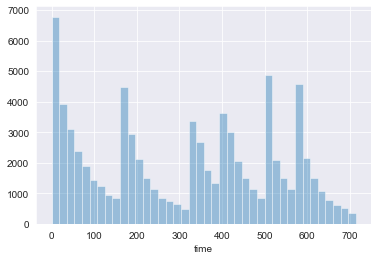

In [68]:
sns.set_style('darkgrid')
sns.distplot(transcript_2["time"],kde=False)

One can see that in many instances the number of hours is quite high. Let's convert the measurement from hours to days instead.

In [69]:
transcript_2['days_since_test'] = transcript_2['time'] // 24 # divison without remainders
transcript_2.drop(columns = 'time', inplace = True)

The second dataset is now processed and ready for merging to create a complete dataset.

## Examine Dataset Three: Profile

In [64]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   customer_id       17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [63]:
profile.head()

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


As written on Kaggle, **ID** refers to **Customer ID** and therefore we will rename the column.

In [70]:
profile.rename(columns = {'id':'customer_id'},inplace=True)

One can observe that the profile dataset contains missing values for **Gender** and **Income**. In fact, they show the exact same total number of missing values. We have 2175 missing entries for **Ggender**. We can see in the output of .info() that **Income** has the same number of missing values. I suspect that for these two columns there are missing data in the same rows. Let's check and then drop these rows.

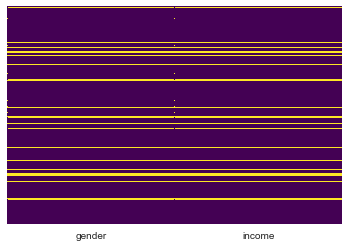

In [22]:
# for a closer comparison
gender_income = profile[["gender", "income"]].copy()
sns.heatmap(gender_income.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [71]:
profile.dropna(inplace=True)
profile.reset_index(inplace=True,drop=True) # resetting the index due to dropped values
profile.isna().sum()

gender              0
age                 0
customer_id         0
became_member_on    0
income              0
dtype: int64

No missing values left.

In [25]:
profile["gender"].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Upon further examination of the **Gender** feature, one can see that 212 customers did not want to give an answer or specify their gender. Let's remove these entries because this will not yield useful insights for our analysis later on. As last step for the **Gender** feature, the column will be dummy-coded and the original column dropped.

In [72]:
profile = profile[profile.gender != 'O']
profile['male'] = profile['gender'].map({'M':1,'F':0}) # 1 is male, 0 is female
profile[['gender','male']] # to check if it worked proprely

,gender,male
0,F,0
1,F,0
2,M,1
3,M,1
4,M,1
...,...,...
14820,F,0
14821,M,1
14822,M,1
14823,F,0


In [73]:
# now we can drop the original column
profile.drop(columns = 'gender', inplace = True) 

The feature **Became Member On** is supposed to be in datetime format. However, this is not the case here. Moreover, in order to be able to use this feature in any machine learning model, it must be feature engineered. 

My approach:

First, convert the current column format (int) to datetime and then calculate the total number of membership days per customer. Lastly, I will drop the old column.


In [74]:
# convert column to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format="%Y%m%d")

In [75]:
# let's see the timeframe the customer data was collected
print(profile["became_member_on"].min(),profile["became_member_on"].max()) 

2013-07-29 00:00:00 2018-07-26 00:00:00


The customer data was collected between July 29th, 2013 and July 26th, 2018

In [76]:
# create a function to convert the column into total number of days
def total_days_converter(start_date, end_date= profile["became_member_on"].max()):
    for date in start_date:
        days = (end_date-start_date)
        return days 

In [77]:
# apply function to perform the conversion
profile["membership_days"] = total_days_converter(profile["became_member_on"])
profile.drop(columns="became_member_on", inplace=True)
profile["membership_days"].head()

0   376 days
1   443 days
2    91 days
3   167 days
4   257 days
Name: membership_days, dtype: timedelta64[ns]

In [79]:
# since we are only interested in the total number of days we can extract the number of days and convert it to integer format
profile['membership_days'] = pd.to_numeric(profile['membership_days'].dt.days, downcast='integer')

The third and final dataset is ready to be used for merging. The **Customer ID** column remains in its current state because it will be used to merge the datasets next. However, this dataset is not yet suitable for machine learning because the 3 datetime columns need more processing which will be conducted later.

## Merging the Three Datasets into a Complete Dataset

**Step 1:** Let's start by merging the cleaned **Transcript** dataset with the **Profile** dataset on **Customer ID**.

In [82]:
# we merge them with "how = 'outer'" to retain all rows even if there is not a match on "customer_id" 
step1 = pd.merge(transcript_2, profile, on="customer_id", how="outer")
step1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79866 entries, 0 to 79865
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         79866 non-null  object 
 1   offer_id            63288 non-null  object 
 2   transaction_amount  16578 non-null  float64
 3   reward              28996 non-null  float64
 4   event               79866 non-null  int64  
 5   days_since_test     79866 non-null  int64  
 6   age                 68741 non-null  float64
 7   income              68741 non-null  float64
 8   male                68741 non-null  float64
 9   membership_days     68741 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 6.7+ MB


**Step 2:** Let's merge the **Step1** dataset with the **Portfolio** dataset on **Offer ID** to create the complete dataset.

In [83]:
step2 = pd.merge(step1, portfolio, on="offer_id", how="outer") # outer to avoid dropping NaNs or no match on Offer ID
step2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79866 entries, 0 to 79865
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         79866 non-null  object 
 1   offer_id            63288 non-null  object 
 2   transaction_amount  16578 non-null  float64
 3   reward_x            28996 non-null  float64
 4   event               79866 non-null  int64  
 5   days_since_test     79866 non-null  int64  
 6   age                 68741 non-null  float64
 7   income              68741 non-null  float64
 8   male                68741 non-null  float64
 9   membership_days     68741 non-null  float64
 10  reward_y            63288 non-null  float64
 11  difficulty          63288 non-null  float64
 12  duration            63288 non-null  float64
 13  email               63288 non-null  float64
 14  mobile              63288 non-null  float64
 15  social              63288 non-null  float64
 16  web 

# Preparing the Complete Dataset

Finally, after merging the datasets into the complete dataset we have to do some last preprocessing steps before we can start with our analysis.
<br>

- drop **Customer ID** and **Offer ID** columns since we are now done with merging datasets and don't need them anymore
- fill NaNs in **Transaction Amount**, **Difficulty**, **Duration, **Email**, **Mobile**, **Social**, **Web**, **Bogo**, **Discount** and **Informational** with 0s
- examine if **reward_x** and **reward_y** are identical and then drop one, fill the remaining NaNs with 0 and rename the feature

In [84]:
step2.drop(columns=["customer_id", "offer_id"], inplace=True)

In [85]:
# fill NaNs in with 0s 
step2["transaction_amount"].fillna(value=0, inplace=True)
step2["difficulty"].fillna(value=0, inplace=True)
step2["duration"].fillna(value=0, inplace=True)
step2["email"].fillna(value=0, inplace=True)
step2["mobile"].fillna(value=0, inplace=True)
step2["social"].fillna(value=0, inplace=True)
step2["web"].fillna(value=0, inplace=True)
step2["bogo"].fillna(value=0, inplace=True)
step2["discount"].fillna(value=0, inplace=True)
step2["informational"].fillna(value=0, inplace=True)

In [86]:
# check if reward_x values are all in reward_y
step2["reward_x"].isin(step2["reward_y"]).all()

True

In [87]:
# this means we can drop reward_x, rename reward_y to reward and fill any missing values with 0
step2.drop(columns="reward_x", inplace=True)
step2.rename(columns={"reward_y" : "reward"},inplace=True)
step2["reward"].fillna(value=0, inplace=True)

Let's check for any additional missing values. If there are still find missing data we will drop them.

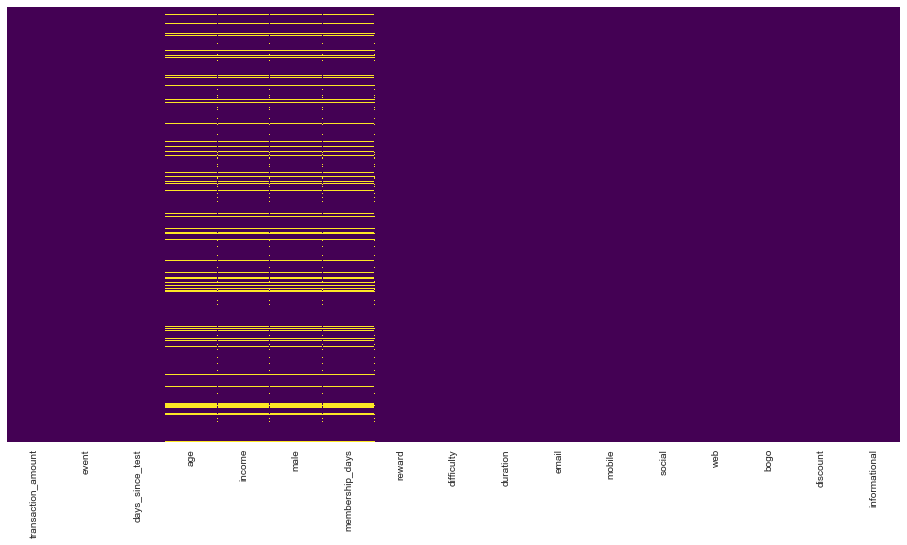

In [41]:
plt.figure(figsize=(16,8))
sns.heatmap(step2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [88]:
# drop NaNs
step2.dropna(inplace=True)
step2.reset_index(inplace=True,drop=True) # resetting the index caused by dropped values
step2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68741 entries, 0 to 68740
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_amount  68741 non-null  float64
 1   event               68741 non-null  int64  
 2   days_since_test     68741 non-null  int64  
 3   age                 68741 non-null  float64
 4   income              68741 non-null  float64
 5   male                68741 non-null  float64
 6   membership_days     68741 non-null  float64
 7   reward              68741 non-null  float64
 8   difficulty          68741 non-null  float64
 9   duration            68741 non-null  float64
 10  email               68741 non-null  float64
 11  mobile              68741 non-null  float64
 12  social              68741 non-null  float64
 13  web                 68741 non-null  float64
 14  bogo                68741 non-null  float64
 15  discount            68741 non-null  float64
 16  info

No missing data left. The final dataset contains 68,741 observations and 17 columns. Let's save it as a csv file and begin with our analysis.

In [89]:
# Write csv file of the step2 data set 
step2.to_csv("starbucks.csv")

# 2) Exploratory Data Analysis (EDA)

In [2]:
# load dataset
df = pd.read_csv("starbucks.csv")

## 1. Summary Statistics

The loaded dataset contains a new column titled "Unnamed: 0" which is presumably added automatically as index. Let's drop this column before conducting the EDA.

In [3]:
df.drop(columns="Unnamed: 0", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68741 entries, 0 to 68740
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_amount  68741 non-null  float64
 1   event               68741 non-null  int64  
 2   days_since_test     68741 non-null  int64  
 3   age                 68741 non-null  float64
 4   income              68741 non-null  float64
 5   male                68741 non-null  float64
 6   membership_days     68741 non-null  float64
 7   reward              68741 non-null  float64
 8   difficulty          68741 non-null  float64
 9   duration            68741 non-null  float64
 10  email               68741 non-null  float64
 11  mobile              68741 non-null  float64
 12  social              68741 non-null  float64
 13  web                 68741 non-null  float64
 14  bogo                68741 non-null  float64
 15  discount            68741 non-null  float64
 16  info

In [92]:
df.head(10)

,transaction_amount,event,days_since_test,age,income,male,membership_days,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,0.0,4,2,45.0,62000.0,0.0,608.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
1,0.0,3,18,71.0,56000.0,1.0,158.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
2,0.0,4,8,71.0,73000.0,1.0,268.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
3,0.0,4,0,69.0,83000.0,0.0,1040.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,0.0,4,7,59.0,93000.0,0.0,329.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
5,0.0,4,2,87.0,47000.0,0.0,498.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
6,0.0,4,21,67.0,95000.0,0.0,5.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
7,0.0,4,20,57.0,118000.0,0.0,1058.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
8,0.0,4,26,50.0,86000.0,1.0,330.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
9,0.0,4,1,43.0,67000.0,0.0,1091.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [93]:
df.describe()

,transaction_amount,event,days_since_test,age,income,male,membership_days,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
count,68741.000000,68741.000000,68741.000000,68741.000000,68741.000000,68741.000000,68741.000000,68741.000000,68741.000000,68741.000000,68741.000000,68741.000000,68741.000000,68741.000000,68741.000000,68741.000000,68741.000000
mean,3.097166,2.865088,12.637742,54.333862,65388.007157,0.581022,523.530295,3.332233,6.116612,5.155831,0.792147,0.711977,0.474768,0.633276,0.316536,0.317365,0.158246
std,15.436389,1.154521,8.742691,17.415733,21655.181548,0.493395,419.954176,3.476804,5.847533,3.290752,0.405774,0.452845,0.499367,0.481914,0.465128,0.465454,0.364974
min,0.000000,1.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,4.000000,42.000000,49000.000000,0.000000,208.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,14.000000,55.000000,64000.000000,1.000000,359.000000,2.000000,5.000000,5.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,4.000000,21.000000,66.000000,80000.000000,1.000000,799.000000,5.000000,10.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,962.100000,4.000000,29.000000,101.000000,120000.000000,1.000000,1823.000000,10.000000,20.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2. Univariate Analysis

**Customer Demographics**

Text(0.5, 0, 'Gender')

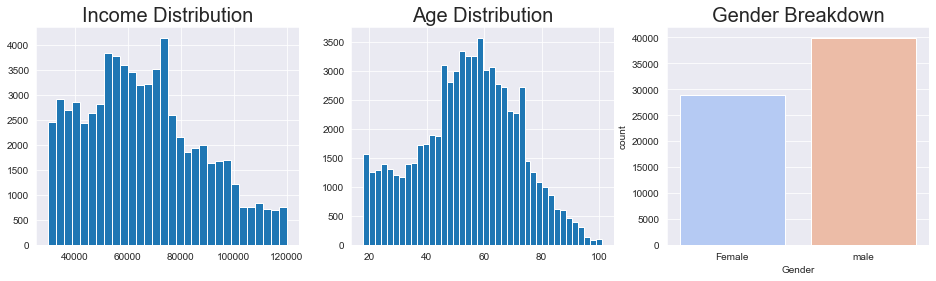

In [94]:
plt.figure(figsize = [16, 4]) # larger figure size for subplots
sns.set_style('darkgrid') # set style

# histogram on income
plt.subplot(1, 3, 1) # 1 row, 3 cols, subplot 1
plt.hist(data = df, x = 'income',bins=30)
plt.title("Income Distribution", size=20)

# histogram on age
plt.subplot(1, 3, 2) # 1 row, 3 cols, subplot 2
plt.hist(data = df, x = 'age', bins=40)
plt.title("Age Distribution", size=20)

# countplot on age
plt.subplot(1, 3, 3) # 1 row, 3 cols, subplot 3
g=sns.countplot(x="male", data=df, palette="coolwarm")
plt.title("Gender Breakdown", size=20)
g.set_xticklabels(labels=("Female","male"))
plt.xlabel("Gender")

From the plots above, one can infer that most customers are aged between 40 and 75 years and have an income between approximately 45,000 and 80,000 US dollars. In terms of gender, the breakdown is relatively balanced however there are more male customers than female.  

In [95]:
print("Female customers: {}%".format(round(df["male"].value_counts()[0] / len(df["male"])*100,2)))
print("Male customers: {}%".format(round(df["male"].value_counts()[1] / len(df["male"])*100,2)))

Female customers: 41.9%
Male customers: 58.1%


**App Account Creation Date and Total Membership Days**

App Account Creating Date

In [41]:
# convert became_member_on to datetime and then extract year
profile['became_member_on'] = pd.to_datetime(profile["became_member_on"], format='%Y%m%d')
profile["year"] =  pd.DatetimeIndex(profile['became_member_on']).year

Text(0.5, 1.0, 'Year of Account Creation')

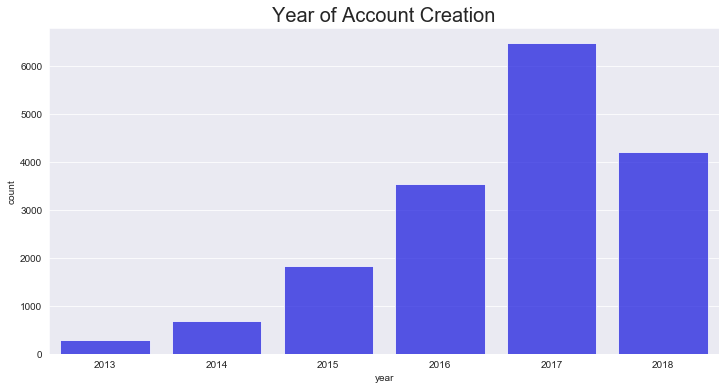

In [48]:
# set style
sns.set_style('darkgrid')

# set figure size
plt.figure(figsize = [12, 6]) 

# countplot on year of account creation
sns.countplot(x=profile["year"], data=profile, color="blue",alpha=0.75) # palette coolwarm or color = teal
plt.title("Year of Account Creation", size=20)

As depicted in the exhibit above, one can see that the customer transaction dataset contains entries from the years 2013 to 2018.One can derive that most customers created their accounts between 2016 and 2018, with 2017 showing the highest number of accounts created. The data set does not contain complete data from the year 2018 which is probably why this year shows a lower total number of accounts created compared to 2017. Generally, this finding makes sense because smartphone ownership experienced rapid growth over the years and mobile payment became slightly more accepted among consumers. However, it is important to note that US consumers still perceive moblile payments as poorly protected compared to traditional payment methods.

Sources:
- https://www.pewresearch.org/internet/fact-sheet/mobile/
- https://www.pewtrusts.org/en/research-and-analysis/issue-briefs/2019/10/are-americans-embracing-mobile-payments

**Response Variable: Offer Completed**

The feature **Offer Completed** is identified as the response variable for this project. Let's take a closer look at our response variable.

[Text(0, 0, 'Transaction'),
 Text(0, 0, 'Offer Received'),
 Text(0, 0, 'Offer Viewed'),
 Text(0, 0, 'Offer Completed')]

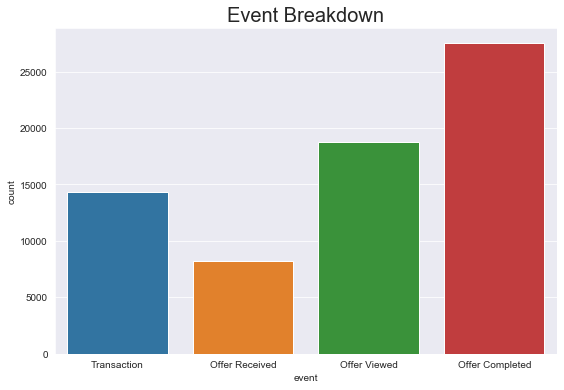

In [58]:
plt.figure(figsize=(9,6))
g = sns.countplot(df["event"])
sns.set_style('darkgrid')
g.set_title('Event Breakdown', size = 20)
g.set_xticklabels(labels=("Transaction","Offer Received","Offer Viewed", "Offer Completed"))

In [98]:
# let's get the exact relative values
print("Transaction: {}%".format((round((df["event"].value_counts()[1] / len(df["event"]) * 100), 2))))
print("Offer Received: {}%".format((round((df["event"].value_counts()[2] / len(df["event"]) * 100), 2))))
print("Offer Viewed: {}%".format((round((df["event"].value_counts()[3] / len(df["event"]) * 100), 2))))
print("Offer Completed: {}%".format((round((df["event"].value_counts()[4] / len(df["event"]) * 100), 2))))

print("\nA total of {}% of customers did not complete an offer and inversely {}% did complete an offer.".format(round(
    ((df["event"].value_counts()[1] / len(df["event"]))+
     (df["event"].value_counts()[2] / len(df["event"]))+
     (df["event"].value_counts()[3] / len(df["event"])))*100,2),     
    (round((df["event"].value_counts()[4] / len(df["event"]) * 100), 2))))

Transaction: 20.79%
Offer Received: 11.94%
Offer Viewed: 27.25%
Offer Completed: 40.02%

A total of 59.98% of customers did not complete an offer and inversely 40.02% did complete an offer.


## 3. Bivariate Analysis

**Offer Completed and Demographics**

Text(0.5, 0, 'Offer Completed')

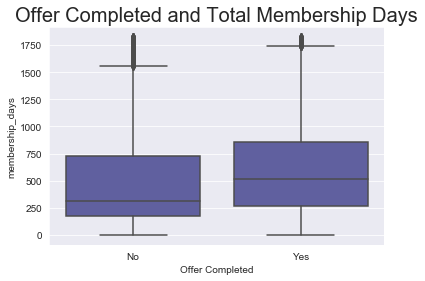

In [126]:
# histogram on year app account created
g=sns.boxplot(x=df["event"]==4,y=df["membership_days"], color="blue",saturation=0.25) # palette coolwarm or color = teal
plt.title("Offer Completed and Total Membership Days", size=20)
g.set_xticklabels(labels=("No","Yes"))
g.set_xlabel("Offer Completed") 

In the boxplot depicted above one can observe that those customers who completed an offer in the past tend to have an app account for longer (approx. 550 days on avg.) than those who did not complete an offer (approx. 300 days on avg.).  

Text(0.5, 0, 'Gender')

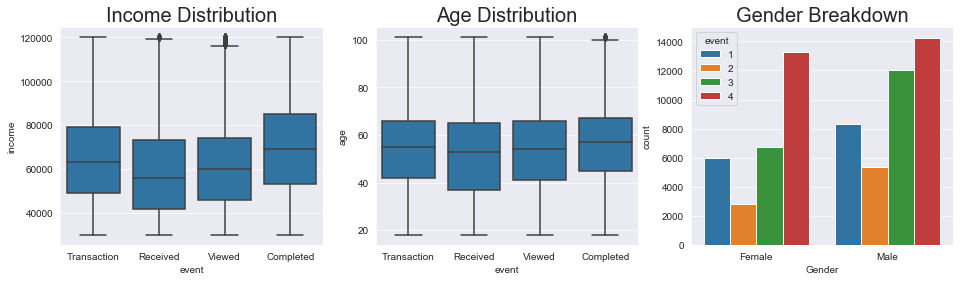

In [106]:
base_color = sns.color_palette()[0]

plt.figure(figsize = [16, 4]) # larger figure size for subplots

# histogram on income
plt.subplot(1, 3, 1) # 1 row, 3 cols, subplot 1
g=sns.boxplot(x="event", y="income",data=df,color = base_color)
g.set_xticklabels(labels=("Transaction","Received","Viewed", "Completed"))
plt.title("Income Distribution", size=20)

# histogram on age
plt.subplot(1, 3, 2) # 1 row, 3 cols, subplot 2
g1=sns.boxplot(x="event", y="age",data=df,color = base_color)
g1.set_xticklabels(labels=("Transaction","Received","Viewed", "Completed"))
plt.title("Age Distribution", size=20)

# countplot on gender
plt.subplot(1, 3, 3) # 1 row, 3 cols, subplot 3
g2=sns.countplot(x="male", hue="event",data=df)
g2.set_xticklabels(labels=("Female","Male"))
plt.title("Gender Breakdown", size=20)
g2.set_xlabel("Gender")

From the bivariate analysis presented above, one can observe that customers who do complete an offer earn slightly more on average than those who did not complete an offer. Furthermore, customers who did complete an offer in the past tend to be slightly older than those who did not. If we look at the breakdown by gender, we can see similar tendencies for both male and female customers. THis could mean that even though there are less females documented in the dataset they almost complete the same amount of offers as men. We can also observe that men conduct more transactions without using any offer. 

In [227]:
# calculate weighted averages
print("Average income of customers who did complete an offer in the past: ${}".format(round(np.average(df["income"], 
                                                                          weights=(df["event"] == 4)),2)))

print("Average income of customers who did not complete an offer: ${}".format(round(np.average(df["income"], 
                                                                          weights=(df["event"] != 4)),2)))
                                                                     
print("Average age of customers who did complete an offer in the past: {} years".format(round(np.average(df["age"], 
                                                                          weights=(df["event"] == 4)),1)))
                                                                                               
print("Average age of customers who did not complete an offer: {} years".format(round(np.average(df["age"], 
                                                                          weights=(df["event"] != 4)),2)))

Average income of customers who did complete an offer in the past: $69398.28
Average income of customers who did not complete an offer: $62711.8
Average age of customers who did complete an offer in the past: 55.8 years
Average age of customers who did not complete an offer: 53.37 years


In [285]:
print("Male: 1 \nFemale: 0\n",df.groupby(['male', 'event']).size())
print("\nProportion of male customers who completed an offer: {}%".format(
     round(df.groupby(['male', 'event']).size()[1][4] / df.groupby(['male', 'event']).size()[1].sum()*100,2)))
print("Proportion of female customers who completed an offer: {}%".format(
     round(df.groupby(['male', 'event']).size()[0][4] / df.groupby(['male', 'event']).size()[0].sum()*100,2)))

Male: 1 
Female: 0
 male  event
0.0   1         5993
      2         2823
      3         6726
      4        13259
1.0   1         8295
      2         5388
      3        12003
      4        14254
dtype: int64

Proportion of male customers who completed an offer: 35.69%
Proportion of female customers who completed an offer: 46.04%


Based on these findings, women tend to react more positively towards the promotions than men since a larger proportion of women completed an offer when compared to men.

**Offer Completed and Discount Types**

Text(0.5, 1.0, 'Received Informational')

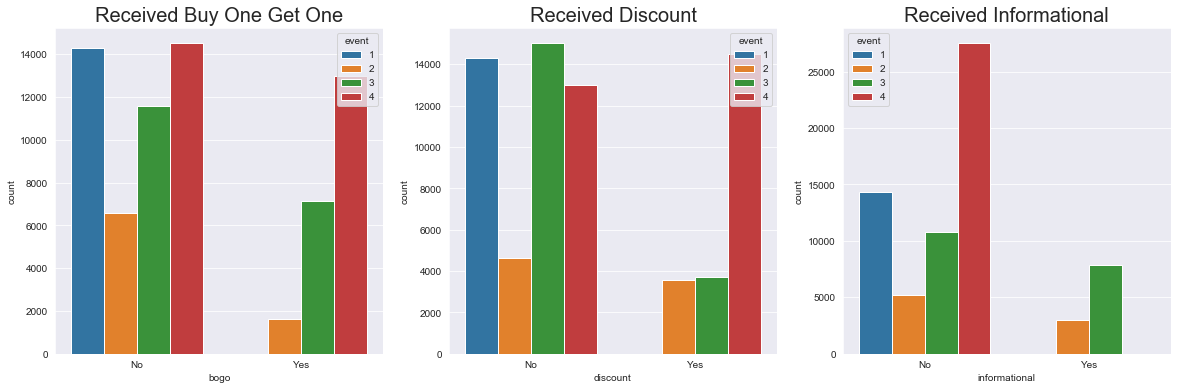

In [302]:
plt.figure(figsize = [20, 6]) # larger figure size for subplots

# countplot on bogo
plt.subplot(1, 3, 1) # 1 row, 3 cols, subplot 1
g=sns.countplot(x="bogo", hue="event", data=df)
g.set_xticklabels(labels=("No","Yes"))
plt.title("Received Buy One Get One", size=20)

# countplot on discount
plt.subplot(1, 3, 2) # 1 row, 3 cols, subplot 2
g1=sns.countplot(x="discount", hue="event", data=df)
g1.set_xticklabels(labels=("No","Yes"))
plt.title("Received Discount", size=20)

# countplot on informational
plt.subplot(1, 3, 3) # 1 row, 3 cols, subplot 3
g2=sns.countplot(x="informational", hue ="event",data=df)
g2.set_xticklabels(labels=("No","Yes"))
plt.title("Received Informational", size=20)

From the visualizations presented above, one can infer that most customers received a **discount** offer, followed by **BOGO** and **informational**, respectively. One can also notice that receiving **informational** offers does not translate to a purchase. The reason for this is because it is probably not possible to track this. It appears that **discount** has the highest success rate among the 3 offer types. Let's confirm this observation.

In [103]:
print("Customers who received BOGO: {}%".format(round((df["bogo"]==1).sum() / len(df)*100,2)))
print("Customers who received Discount: {}%".format(round((df["discount"]==1).sum() / len(df)*100,2)))
print("Customers who received Informational: {}%".format(round((df["informational"]==1).sum() / len(df)*100,2)))
print("Customers who didn't receive an offer: {}%".format(round(len(df.loc[(df['discount'] == 0) & 
                                                                        (df['informational'] == 0) & 
                                                                        (df['bogo'] == 0)])/len(df)*100,2)))

Customers who received BOGO: 31.65%
Customers who received Discount: 31.74%
Customers who received Informational: 15.82%
Customers who didn't receive an offer: 20.79%


In [305]:
print("BOGO success rate: {}%".format(round(df["bogo"].where(df["event"]==4).sum() / (df["bogo"]==1).sum()*100,2)))
print("Discount success rate: {}%".format(round(df["discount"].where(df["event"]==4).sum() / (df["discount"]==1).sum()*100,2)))
print("Informational success rate: {}%".format(round(df["informational"].where(df["event"]==4).sum() / (df["informational"]==1).sum()*100,2)))

BOGO success rate: 59.69%
Discount success rate: 66.58%
Informational success rate: 0.0%


In fact, **discounts** show the highest success rate among the 3 offer types and is also the most frequent promotion sent to customers. Furthermore, out of all offers sent out to customers, **informational** promotions make up approx. 15% of offers. 20.79% of customers did not receive any promotion. This could be improved by sending discounts to these customers in order to incentivize them to complete an offer.

**Offer Completed and Communication Channels**


Text(0.5, 1.0, 'Email')

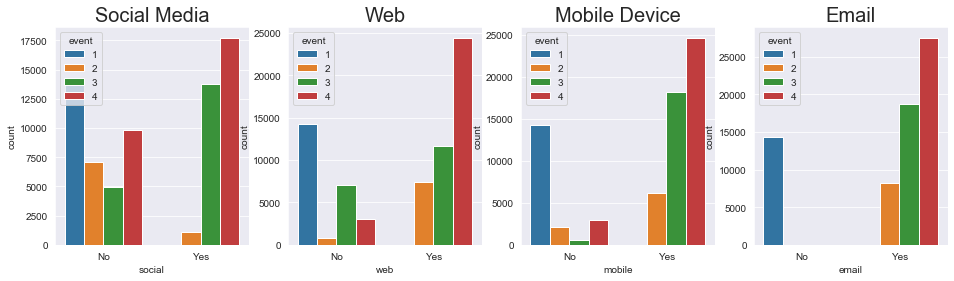

In [111]:
plt.figure(figsize = [16, 4]) # larger figure size for subplots

# countplot on social media
plt.subplot(1, 4, 1) # 1 row, 4 cols, subplot 1
g=sns.countplot(x="social", hue=df["event"], data=df)
g.set_xticklabels(labels=("No","Yes"))
plt.title("Social Media", size=20)

# countplot on web
plt.subplot(1, 4, 2) # 1 row, 4 cols, subplot 2
g1=sns.countplot(x="web", hue="event", data=df)
g1.set_xticklabels(labels=("No","Yes"))
plt.title("Web", size=20)

# countplot on mobile device
plt.subplot(1, 4, 3) # 1 row, 4 cols, subplot 3
g2=sns.countplot(x="mobile", hue ="event",data=df)
g2.set_xticklabels(labels=("No","Yes"))
plt.title("Mobile Device", size=20)

# countplot on email
plt.subplot(1, 4, 4) # 1 row, 4 cols, subplot 4
g2=sns.countplot(x="email", hue ="event",data=df)
g2.set_xticklabels(labels=("No","Yes"))
plt.title("Email", size=20)

In [70]:
print("Customers contacted via social media: {}%".format(round((df["social"]==1).sum() / len(df)*100,2)))
print("Customers contacted via web: {}%".format(round((df["web"]==1).sum() / len(df)*100,2)))
print("Customers contacted via mobile device: {}%".format(round((df["mobile"]==1).sum() / len(df)*100,2)))
print("Customers contacted via email: {}%".format(round((df["email"]==1).sum() / len(df)*100,2)))

print("\nCustomers not contacted at all: {}%".format(round(len(df.loc[(df['social'] == 0) & 
                                                                    (df['web'] == 0)    & 
                                                                    (df['social'] == 0) &
                                                                    (df['mobile'] == 0)])/len(df)*100,2)))
print("\n**Note: Customers can be contacted through 0 or multiple contact methods.")

Customers contacted via social media: 47.48%
Customers contacted via web: 63.33%
Customers contacted via mobile device: 71.2%
Customers contacted via email: 79.21%

Customers not contacted at all: 20.79%

**Note: Customers can be contacted through 0 or multiple contact methods.


In [78]:
print("Social media success rate: {}%".format(round(df["social"].where(df["event"]==4).sum() / (df["social"]==1).sum()*100,2)))
print("Web success rate: {}%".format(round(df["web"].where(df["event"]==4).sum() / (df["web"]==1).sum()*100,2)))
print("Mobile success rate: {}%".format(round(df["mobile"].where(df["event"]==4).sum() / (df["mobile"]==1).sum()*100,2)))
print("Email success rate: {}%".format(round(df["email"].where(df["event"]==4).sum() / (df["email"]==1).sum()*100,2)))

Social media success rate: 54.31%
Web success rate: 56.09%
Mobile success rate: 50.3%
Email success rate: 50.53%


Derived from the findings above, customers contacted through **web** led to the highest success rate among the 4 contact methods. This is followed by **social media** as second most effective channel to reach customers. While **mobile** and **email** are the 2 contact methods utlized the most, they have the lowest success rate among the 4 contact methods.

**Event Compared to Difficulty and Duration**

Text(0.5, 1.0, 'Event Compared to Duration in Days')

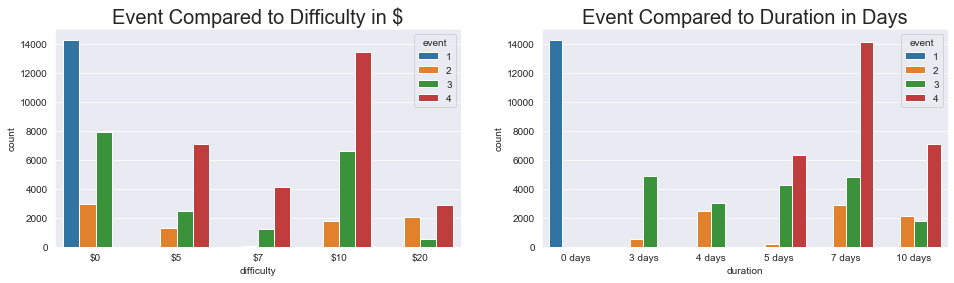

In [361]:
plt.figure(figsize = [16, 4]) # larger figure size for subplots

# countplot on social media
plt.subplot(1, 2, 1) # 1 row, 3 cols, subplot 1
g=sns.countplot(x="difficulty", hue="event", data=df)
g.set_xticklabels(labels=("$0", "$5", "$7", "$10", "$20"))
plt.title("Event Compared to Difficulty in $", size=20)

# countplot on web
plt.subplot(1, 2, 2) # 1 row, 3 cols, subplot 2
g1=sns.countplot(x="duration", hue="event", data=df)
g1.set_xticklabels(labels=("0 days", "3 days", "4 days", "5 days", "7 days", "10 days"))
plt.title("Event Compared to Duration in Days", size=20)

- Difficulty refers to the amount of money a customer has to spend in order to be eligible for a reward. 
- Duration refers to the number of days a discount is valid

From the plots presented above, one can infer that a difficulty level of 10 USD leads to the most completed offers, followed by a level of 5 USD. In terms of duration, most offers were completed for promotions that were only valid for 7 days, followed by 10 days and 5 days respectively. No offers were completed for offers that are only valid for 3 or 4 days.

# 3) Data Preparation

**Dummy Coding Features**

In [4]:
# dummy coding the Event feature
df_dummies = pd.get_dummies(df['event'])

# combine the df_dummies with the transcript dataframe
df = pd.concat([df, df_dummies], axis=1)

# rename columns to more suitable names
df.rename(columns = {4:'offer_completed', 
                     3:'offer_viewed',
                     2:'offer_received',
                     1:'transaction'
                     },inplace=True)

# let's drop transaction because this information is included in transaction_amount
df.drop(columns=["event","transaction"], inplace=True) 
df.head()

,transaction_amount,days_since_test,age,income,male,membership_days,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,offer_received,offer_viewed,offer_completed
0,0.0,2,45.0,62000.0,0.0,608.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,1
1,0.0,18,71.0,56000.0,1.0,158.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,1,0
2,0.0,8,71.0,73000.0,1.0,268.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,1
3,0.0,0,69.0,83000.0,0.0,1040.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,1
4,0.0,7,59.0,93000.0,0.0,329.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,1


After examining the output depicted above, we can determine that the dummy-coding worked as intended. Dummy-codeing the **Event** feature resulted in 4 columns from which we dropped **Transaction** because whether or not a transaction was performed is known as soon as we have a value greater than 0 in **Transaction Amount**.

However, we could still use 3 out of these 4 columns to perfectly predict the 4th column:
- Transaction Amount
- Offer Completed
- Offer Viewed
- Offer Received

In other words, we now deal with the dummy trap problem which is undesirable for machine learning. Therefore, let's drop the **Offer Received** column to avoid this issue.

**Important Note:** Since machine learning projects are iterative projects, it was determined that keeping **Offer Viewed** over **Offer Received** will result in much higher predictive accuracy.

In [5]:
df.drop(columns="offer_received",inplace=True)

**Examine Feature Correlations**

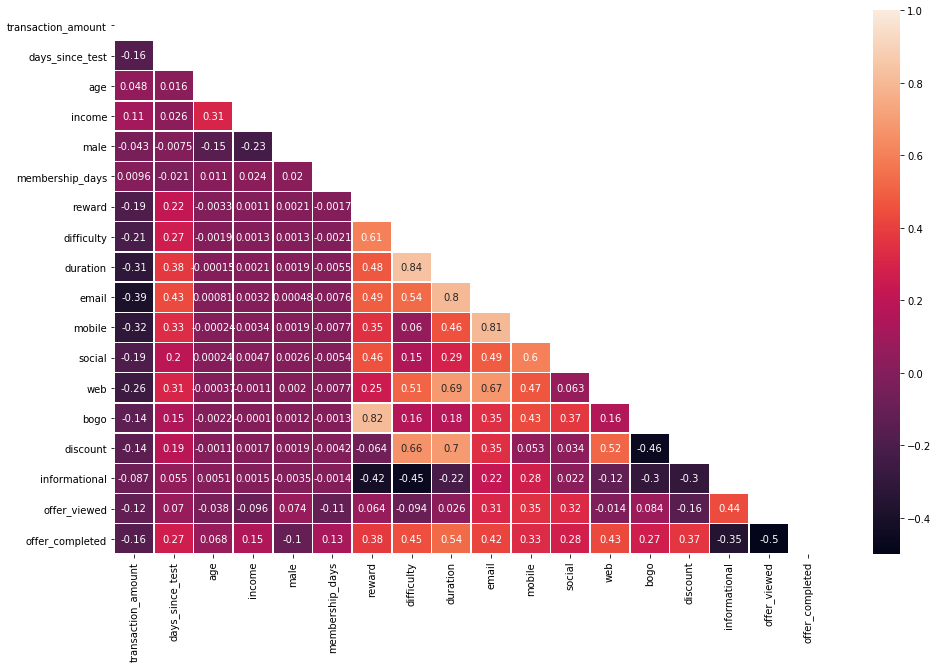

In [6]:
plt.figure(figsize=(16,10))
# Compute the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# plot heatmap
sns.heatmap(df.corr(),yticklabels=True, annot=True,mask=mask,linewidths=.5)

We can see some relatively highly correlated variables (> 0.7). Let's drop **Duration** and **Difficulty**.

In [6]:
df.drop(columns="duration", inplace=True) 
df.drop(columns="difficulty", inplace=True) 

**Feature Correlation on Dependend Variable Offer Completed**

In [9]:
df.corr()["offer_completed"].sort_values()

offer_viewed         -0.499911
informational        -0.354199
transaction_amount   -0.163906
male                 -0.104208
age                   0.067917
membership_days       0.125625
income                0.151282
days_since_test       0.272021
bogo                  0.273163
social                0.277122
mobile                0.329895
discount              0.369564
reward                0.381698
email                 0.418454
web                   0.430898
offer_completed       1.000000
Name: offer_completed, dtype: float64

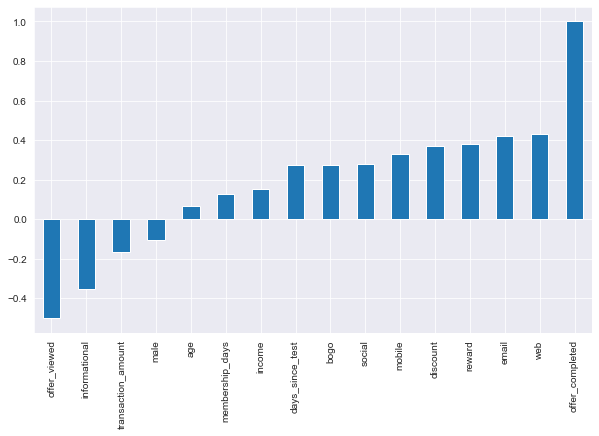

In [10]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
df.corr()["offer_completed"].sort_values().plot(kind="bar")

We ignore **Offer Completed** in the plot presented above since it goes without saying that it has 100% correlation with itself. It looks like **web**, **email**, **reward** and **discount** have a moderately positive correlation with the response variable. On the other hand, **informational** and **offer viewed** show a moderately negative correlation with the outcome.

**Create Training, Validation and Test Split**

In [7]:
# Split the data into training, validation and test datasets 
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=1)

# separate the DV from the train/validation/test sets
X_train = df_train.drop(['offer_completed'], axis=1)
y_train = df_train.offer_completed.values
X_valid = df_valid.drop(['offer_completed'], axis=1)
y_valid = df_valid.offer_completed.values
X_test = df_test.drop(['offer_completed'], axis=1)
y_test = df_test.offer_completed.values

**Feature Scaling**

In [8]:
# Since we have many different types of features in our dataset e.g. age, income etc. we should normalize the data

# create an instance of MinMaxScaler
scaler = MinMaxScaler().fit(X_train)

# now perform the transformations on the training, validation and test set
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print("Training Data:", X_train.shape, y_train.shape,"\nValidation Data:", X_valid.shape, y_valid.shape,
      "\nTest Data:", X_test.shape, y_test.shape)

Training Data: (43993, 15) (43993,) 
Validation Data: (13749, 15) (13749,) 
Test Data: (10999, 15) (10999,)


# 4) Model Building and Validation

**Baseline Accuracy to Beat**

Let's take a naive approach as a baseline accuracy value to beat for all predictive models. Let's follow a "most frequent” approach. This approach looks at our response variable and always predicts the most frequent label. For our our response variable that would be:


In [11]:
print("Accuracy if we assume no customers complete an offer: {}%".format(round((df["offer_completed"]==0).sum() / len(df)*100,2)))

Accuracy if we assume no customers complete an offer: 59.98%


## Model 1: Random Forest

**Training the model**

In [11]:
# build RandomForestClassifier instance and fit on training data
rfc = RandomForestClassifier() # use default parameters first
rfc.fit(X_train, y_train)

#Addressing class imbalance by setting an inverse weight ratio
#class_weight = {0: sum(y_train==1) / len(y_train), 1: sum(y_train==0) / len(y_train)}
#class_weight

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

**Validating the Model's Performance**

In [12]:
# predict on the validation set
y_pred = rfc.predict(X_valid)
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred)))
print("\nValidation Accuracy: {:.2f}%\n \n".format(accuracy_score(y_valid, y_pred)*100))

Confusion Matrix
 [[7744  459]
 [ 202 5344]]

Validation Accuracy: 95.19%
 



95.19% accuracy is already pretty high. We already beat the baseline accuracy goal by just taking the default model parameters.

#### Random Forest: Tuning Model Hyperparameters with Grid Search

**Training the Model**

Let's see if we can improve our results.

In [100]:
# Create arbitary parameter grid for random search (keeping them modest due to low computational power)
param_grid = {'bootstrap'        : [True],
              'max_depth'        : [3, 5, 7, 10, 15],
              'max_features'     : [5, 10, 13, 14, 15],
             'min_samples_leaf'  : [3, 4, 5, 6, 7, 9],
              'min_samples_split': [2, 3,4, 5, 7],
              'n_estimators'     : [100, 150, 300]
             }

# Create the base model
rf = RandomForestClassifier()

# Create the grid search 
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose = 2, n_jobs=-1, return_train_score=True)

In [101]:
# fit grid search on the training data
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 2250 candidates, totalling 6750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 46.3min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 57.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 75.0min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 90.6min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 129.4min
[Parallel(n_jobs=-1)]: Done 6750 out of 6750 | elapsed: 151.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [102]:
# get best parameters from grid search
grid_search_rf.best_params_ 

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 15,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 300}

**Validating Our Model**

In [103]:
# define the best model parameters 
best_grid = grid_search_rf.best_estimator_

# predict on validation data with best parameters
y_pred1 = best_grid.predict(X_valid)

# show confusion matrix and accuracy
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred1)))
print("\nValidation Accuracy: {:.2f}%\n \n".format(accuracy_score(y_valid, y_pred1)*100))

Confusion Matrix
 [[7875  328]
 [ 187 5359]]

Validation Accuracy: 96.25%
 



Once we are content with our validation accuracy we can use our model to predict the test data.

**Using the Model to Predict Test Data**

In [104]:
# make predictions on test data  
y_pred2 = best_grid.predict(X_test)

# get confusion matrix, test accuracy
print("Confusion Matrix\n {}".format(confusion_matrix(y_test, y_pred2)))
print("\nTest Accuracy: {:.2f}%\n \n".format(accuracy_score(y_test, y_pred2)*100))

# get classification report
print(classification_report(y_test, y_pred2))

Confusion Matrix
 [[6306  254]
 [ 165 4274]]

Test Accuracy: 96.19%
 

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      6560
           1       0.94      0.96      0.95      4439

    accuracy                           0.96     10999
   macro avg       0.96      0.96      0.96     10999
weighted avg       0.96      0.96      0.96     10999



The final test accuracy equals 96.24%.

## Model 2: Neural Network Classifier

**Training and Validating the Model**

- Defining our model by creating a Sequential model and adding layers
- Compiling our model by specifing the loss function and optimizer

In [25]:
# create the nn model
nn = keras.Sequential()
nn.add(Dense(units=15,activation="relu"))
nn.add(Dropout(0.5))
nn.add(Dense(units=8,activation="relu"))
nn.add(Dropout(0.5))
nn.add(Dense(units=4,activation="relu"))
nn.add(Dropout(0.5))
# binary classification so we choose sigmoid activation function
nn.add(Dense(units=1,activation="sigmoid")) # one output unit because we deal with binary classification
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [26]:
# fit the model on the training data 
history = nn.fit(X_train, y_train, epochs = 100, batch_size=32, validation_data=(X_valid, y_valid), workers=-1).history

Epoch 1/100
1375/1375 [==============================] - 1s 849us/step - loss: 0.5998 - accuracy: 0.6645 - val_loss: 0.2672 - val_accuracy: 0.9225
Epoch 2/100
1375/1375 [==============================] - 1s 807us/step - loss: 0.4079 - accuracy: 0.8039 - val_loss: 0.1724 - val_accuracy: 0.9284
Epoch 3/100
1375/1375 [==============================] - 1s 854us/step - loss: 0.3694 - accuracy: 0.8212 - val_loss: 0.1650 - val_accuracy: 0.9297
Epoch 4/100
1375/1375 [==============================] - 1s 825us/step - loss: 0.3542 - accuracy: 0.8277 - val_loss: 0.1562 - val_accuracy: 0.9318
Epoch 5/100
1375/1375 [==============================] - 1s 806us/step - loss: 0.3440 - accuracy: 0.8348 - val_loss: 0.1570 - val_accuracy: 0.9356
Epoch 6/100
1375/1375 [==============================] - 1s 851us/step - loss: 0.3383 - accuracy: 0.8400 - val_loss: 0.1554 - val_accuracy: 0.9390
Epoch 7/100
1375/1375 [==============================] - 1s 816us/step - loss: 0.3418 - accuracy: 0.8349 - val_loss: 0

In [45]:
print("Neural Network Classifier average validation accuracy: {}".format(losses["val_accuracy"].mean()))


Neural Network Classifier average validation accuracy: 0.9373714482784271


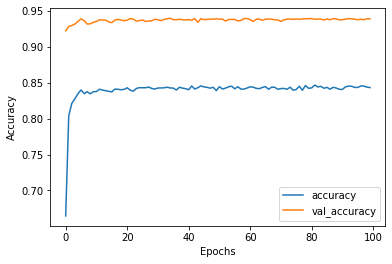

In [37]:
losses = pd.DataFrame(nn.history.history)
losses["accuracy"].plot()
losses["val_accuracy"].plot()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

The neural network classifier shows an average validation accuracy of around 93.74%. We can also see that the accuracy value stagnated after around 5-10 epochs. Consequently, it is slightly worse than the Random Forest model. However, we simply used the default parameters thus far. Let's try to improve the accuracy.

#### Neural Network Classifier: Tuning Model Hyperparameters with Grid Search

**Training the Model**

Let's see if we can improve our results.

- Defining our model by creating a Sequential model and adding layers
- Compiling our model by specifing the loss function and optimizer

In [ ]:
# create the nn model
def build_model(lr=0.01):
    '''
    This function builds a neural network classifier.
    '''
    nn = Sequential()
    nn.add(Dense(units=15,activation="relu")) # 17 because 17 input features
    nn.add(Dropout(0.5))
    nn.add(Dense(units=8,activation="relu"))
    nn.add(Dropout(0.5))
    nn.add(Dense(units=4,activation="relu"))
    nn.add(Dropout(0.5))
    # binary classification so we choose sigmoid activation function
    nn.add(Dense(units=1,activation="sigmoid")) # one output unit because we deal with binary classification
    # set optimizer
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    nn.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    
    return nn

In [ ]:
# Create the actual model
model = KerasClassifier(build_fn=build_model, batch_size=32, epochs=10)

In [69]:
# Create arbitary parameter grid for random search (keeping them modest due to low computational power)
batch_size = [16, 32, 64]
epochs = [100, 200]
learn_rate = [0.0001, 0.001, 0.01, 0.1]

# create the parameter grid
param_grid = dict(lr=learn_rate, batch_size=batch_size,epochs=epochs)

# build the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=10, return_train_score=True)

In [70]:
# fit grid search on the training data
grid_results = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 28.1min
[Parallel(n_jobs=10)]: Done  72 out of  72 | elapsed: 52.9min finished


Epoch 1/200
688/688 [==============================] - 1s 752us/step - loss: 0.5790 - accuracy: 0.6689
Epoch 2/200
688/688 [==============================] - 1s 755us/step - loss: 0.4042 - accuracy: 0.7925
Epoch 3/200
688/688 [==============================] - 1s 770us/step - loss: 0.3569 - accuracy: 0.8191
Epoch 4/200
688/688 [==============================] - 1s 1ms/step - loss: 0.3433 - accuracy: 0.8244
Epoch 5/200
688/688 [==============================] - 1s 839us/step - loss: 0.3401 - accuracy: 0.8270
Epoch 6/200
688/688 [==============================] - 1s 796us/step - loss: 0.3329 - accuracy: 0.8265
Epoch 7/200
688/688 [==============================] - 1s 797us/step - loss: 0.3315 - accuracy: 0.8292
Epoch 8/200
688/688 [==============================] - 1s 752us/step - loss: 0.3314 - accuracy: 0.8283
Epoch 9/200
688/688 [==============================] - 1s 796us/step - loss: 0.3262 - accuracy: 0.8322
Epoch 10/200
688/688 [==============================] - 1s 738us/step - los

688/688 [==============================] - 1s 771us/step - loss: 0.3178 - accuracy: 0.8405
Epoch 158/200
688/688 [==============================] - 1s 748us/step - loss: 0.3162 - accuracy: 0.8395
Epoch 159/200
688/688 [==============================] - 1s 736us/step - loss: 0.3201 - accuracy: 0.8345
Epoch 160/200
688/688 [==============================] - 1s 1ms/step - loss: 0.3145 - accuracy: 0.8376
Epoch 161/200
688/688 [==============================] - 1s 822us/step - loss: 0.3200 - accuracy: 0.8361
Epoch 162/200
688/688 [==============================] - 1s 783us/step - loss: 0.3196 - accuracy: 0.8361
Epoch 163/200
688/688 [==============================] - 1s 754us/step - loss: 0.3157 - accuracy: 0.8388
Epoch 164/200
688/688 [==============================] - 0s 719us/step - loss: 0.3173 - accuracy: 0.8385
Epoch 165/200
688/688 [==============================] - 1s 765us/step - loss: 0.3125 - accuracy: 0.8425
Epoch 166/200
688/688 [==============================] - 1s 774us/step 

In [71]:
# get best parameters from grid search
grid_results.best_params_

{'batch_size': 64, 'epochs': 200, 'lr': 0.001}

**Validating the Model's Performance**

In [72]:
# define the best model parameters 
best_grid = grid_results.best_estimator_

# predict on validation data with best parameters
y_pred3 = best_grid.predict(X_valid)

# show confusion matrix and accuracy
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred3)))
print("\nValidation Accuracy: {:.2f}%\n \n".format(accuracy_score(y_valid, y_pred3)*100))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Confusion Matrix
 [[7664  539]
 [ 283 5263]]

Validation Accuracy: 94.02%
 



Once we are content with our validation accuracy we can use our model to predict the test data.

**Using the Model to Predict Test Data**

In [77]:
# make predictions on test data  
y_pred4 = best_grid.predict(X_test)

# get confusion matrix, test accuracy
print("Confusion Matrix\n {}".format(confusion_matrix(y_test, y_pred4)))
print("\nTest Accuracy: {:.2f}%\n \n".format(accuracy_score(y_test, y_pred4)*100))

# get classification report
print(classification_report(y_test, y_pred4))

Confusion Matrix
 [[6150  410]
 [ 246 4193]]

Test Accuracy: 94.04%
 

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      6560
           1       0.91      0.94      0.93      4439

    accuracy                           0.94     10999
   macro avg       0.94      0.94      0.94     10999
weighted avg       0.94      0.94      0.94     10999



## Model 3: XGBoost
<br>

XGBoost or eXtreme Gradient Boosting is an advanced implementation of the gradient boosting algorithm.
XGBoost is a great choice here because the dataset is quite large with initially 68,741 observations. This is because it is very computationally efficient and typically yields very high accuracy.

**Training The Model**

In [78]:
# set up the classifier. Once again we will use the default parameters as starting point
xgbc = XGBClassifier()

# fit the model on the training set
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Validating the Model's Performance**

In [79]:
# predict validation data
y_pred5 = xgbc.predict(X_valid)

# show model performance on test data
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred5)))
print("Validation Accuracy: {:.2f}%".format(accuracy_score(y_valid, y_pred5)*100))

Confusion Matrix
 [[7904  299]
 [ 202 5344]]
Validation Accuracy: 96.36%


As expected, even with default parameters XGBoost yields very high predictive accuracy. In fact, it already shows the highest accuracy among the 3 predictive models without parameter tuning.

#### XGBoost Classifier: Tuning Model Hyperparameters with Grid Search

Here we will tune some of the hyperparameters to boost the model's performance. It won't find the optimal solution, but a solution that is sufficient considering the limited resources available.

**Training The Model**

In [19]:
# define the classifier
xgbc = XGBClassifier()

# defining parameter grid for XGBoost
parameters = {"eta"                  : [0.01, 0.1, 0.2],
              "max_depth"            : [1,2,3, 4, 5,],
           #  "min_child_weight"     : [1,2,5,10,20,30],
              "colsample_bytree"     : [0.5, 0.6, 0.9],
            #  "subsample"            : [0.5, 0.9, 1.0], # subsample ratio of the training instances, prevents overfitting
              "n_estimators"         : [50,100,150,200]
             }

# setting up the random grid search
grid_search_xgb = GridSearchCV(estimator = xgbc, param_grid = parameters, cv=3, verbose=2, n_jobs=-1, return_train_score=True)
# fit grid search on the training data
grid_results = grid_search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 3600 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 41.6min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 49.0min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 59.8min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

In [16]:
grid_results.best_params_
#'colsample_bytree': 0.5, 'eta': 0.2, 'max_depth': 4, 'n_estimators': 100}  96.61% 

{'colsample_bytree': 0.5, 'eta': 0.2, 'max_depth': 4, 'n_estimators': 100}

In [17]:
# predict validation data
y_pred5 = grid_results.predict(X_valid)

# show model performance on test data
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred5)))
print("Validation Accuracy: {:.2f}%".format(accuracy_score(y_valid, y_pred5)*100))

Confusion Matrix
 [[7913  290]
 [ 176 5370]]
Validation Accuracy: 96.61%


**Using the Model to Predict Test Data**

In [24]:
# let's use the trained XBG model to predict the test data 
y_pred9 = grid_results.predict(X_test)

# show model performance on test data
print("Confusion Matrix\n {}".format(confusion_matrix(y_test, y_pred9)))
print("\nTest Accuracy: {:.2f}%\n \n".format(accuracy_score(y_test, y_pred9)*100))

# get classification report
print(classification_report(y_test, y_pred9))

Confusion Matrix
 [[6337  223]
 [ 161 4278]]

Test Accuracy: 96.51%
 

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      6560
           1       0.95      0.96      0.96      4439

    accuracy                           0.97     10999
   macro avg       0.96      0.96      0.96     10999
weighted avg       0.97      0.97      0.97     10999



## Model Comparison

In [25]:
print("Random Forest\nValidation Accuracy:{}% \nTest Accuracy: {}%".format(96.25, 96.19))
print("\nNeural Network\nValidation Accuracy: {}%\nTest Accuracy: {}%".format(94.02, 94.04))
print("\nXGBoost\nValidation Accuracy: {}%\nTest Accuracy: {}%\n".format(96.61, 96.51))

Random Forest
Validation Accuracy:96.25% 
Test Accuracy: 96.19%

Neural Network
Validation Accuracy: 94.02%
Test Accuracy: 94.04%

XGBoost
Validation Accuracy: 96.61%
Test Accuracy: 96.51%



It goes without saying that there is still room for improvement which could be achieved through e.g. the usage of increased computational power and more time for the model training process. For instance, 3-Fold CV was chosen to save time during the training process which could be increased to 5 or 10-fold CV for better model generalization. Further, with more computational power, the neural network classifier could be trained again and will certainly yield much better results. Nonetheless, a test accuracy of 96.51% is decent.

# 5) Saving the Best Performing Model: XGBoost

In [26]:
# Save to file to working directory
joblib_file = "joblib_final_model.pkl"
joblib.dump(grid_results, joblib_file)

['joblib_final_model.pkl']

In [27]:
# Load from file
final_model = joblib.load("joblib_final_model.pkl")

In [28]:
# Calculate the accuracy and predictions
score = final_model.score(X_test, y_test)
print("Test Accuracy: {0:.2f} %".format(100 * score))

Test Accuracy: 96.51 %


**Successfully saved the final model. It is now ready for deployment.** 

# 6) Conclusion

In summary, the data analysis findings and the development of the classification prediction model, aiming to accurately predict customers with a high likelihood of completing an offer, resulted in the following insights described below.

**Demographics**
- Most customers are roughly aged between 40 and 75 years with an average age of around 54 years
- 41.9% female and 58.1% male customers 
- Average customer income equals 65,388.01 US dollars
- Only 40.02% of customers did complete an offer in the past
- Average income of customers who did complete an offer in the past: 69,398.28 US dollars (vs. 62,711.8 US dollars of those who did not)
- Average age of customers who did complete an offer in the past: 55.8 years (vs. 53.37 years of those who did not)
- The proportion of female customers who completed an offer is higher than male customers (46.04% vs. 35.69%)


Based on these findings, women tend to react more positively towards the promotions than men. Despite the fact that women only make up around 40% of the customers in the dataset provided, they almost contribute the same number of **completed offers** than men. (13,260 women vs. 14.254 men).

**Offers**
- Customers who received **Discount**: 31.74%
- Customers who received **BOGO**: 31.65%
- Customers who didn't receive an offer: 20.79%
- Customers who received **Informational**: 15.82%

- The offer type with the highest success rate is **Discount** (66.58%), followed by **BOGO** (59.69%)
- **Informational** offers can not be traced to any sales

Generally, **discounts** show the highest success rate among the 3 offer types and are also the most frequent promotion sent to customers. Furthermore, out of all offers sent out to customers, **informational** promotions make up approx. 15% of offers. 20.79% of customers did not receive any promotion. 

In terms of difficulty and duration, one can infer that a difficulty level of 10 USD leads to the most completed offers, followed by a level of 5 USD. Further, most offers were completed for promotions that were only valid for 7 days, followed by 10 days and 5 days respectively. No offers were completed for offers that are only valid for 3 or 4 days.

**Contact Methods**

When comparing the 4 contact methods used (email, mobile, social, web), most customers were contacted via email and mobile device. However, both of these contact methods showed a lower success rate of customers completing an offer compared to social media and web. 

- Customers contacted via email: 79.21%
- Customers contacted via mobile device: 71.2%
- Customers contacted via web: 63.33%
- Customers contacted via social media: 47.48%


- Web success rate: 56.09%
- Social media success rate: 54.31%
- Email success rate: 50.53%
- Mobile success rate: 50.3%

**Predictive Model**

We built and tuned 3 classifiaction prediction models with the goal to accurately predict our target customers. Our target customer sare defined as customers who have a high likelihood of completing an offer. The 3 models are Random Forest, Neural Network and eXtreme Gradient Boosting (XGBoost). After training and validating the model performance the following results were geneated:

- The Random Forest Classifier showed a predictive accuracy of 96.19%
- The Neural Network Classifier showed a predictive accuracy of 94.04%
- The **XBGoost** Classifier showed a predictive accuracy of **96.51%** 

Based on these results, we selected XGBoost as the final classifiaction prediction model with which we managed to predict our target customers with approximately 88.65% accuracy.

### Recommendations

In order to increase the company's marketing strategy effectiveness, we derived the following 3 recommendations based on the analysis findings above.

**1) Predicting Target Customers**
- Identify target customers using the XGBoost model

**2) Choosing the right Contact Method(s)**

Increase the usage of the following communication channel(s) to send offers:
- Web (because it showed the highest success rate among the 4 contact methods)
- Social media (because it showed the second highest success rate among the 4 contact methods)

**3) Customizing the Offer Appropriately**
- Send out more discounts beacuse they show the highest success rate
- Keep the amount of BOGO the same beacuse they still show a decent success rate
- Tailor the period an offer is valid around 7 - 10 days because this period showed the highest completed offers
- Avoid making offers valid for only 3 - 4 days because these offers didn't result in any completed offers

The goal is to decrease the total number of customers who did not receive an offer (20.79%) and to increase the success rate of offers sent out (currently 40.02%). This can be done by increasingly targeting female customers who match the target customer profile of customers with slightly above average income (69,398.28 US dollars) and age (55.8 years).

Following these recommendations will ensure a more efficient allocation of resources, an increase in the marketing success rate and ultimately growth in profitability for the organization.